In [1]:
import glob
import enum
import time
import random
import multiprocessing
from pathlib import Path

import torch
import torchvision
import torchio as tio
import torch.nn.functional as F

import numpy as np
from unet import UNet
from scipy import stats
# from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.model_selection import KFold, train_test_split
from torch.utils.data import DataLoader, SubsetRandomSampler
import matplotlib.pyplot as plt

from IPython import display
from tqdm.auto import tqdm

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
num_workers = 0
batch_size = 1
num_epochs = 30
k = 5                # num k-folds
threshold = 0.5      # for binary mask
seed = 88
random.seed(seed)
torch.manual_seed(seed)

In [2]:
print(torch.cuda.is_available())

True


Load files

In [2]:
file_dir = "./dataset"
raw_dir = r'{0}/raw/*.nii'.format(file_dir)
label_dir = r'{0}/label/*.nii'.format(file_dir)

image_paths = sorted(glob.glob(raw_dir))
label_paths = sorted(glob.glob(label_dir))
assert len(image_paths) == len(label_paths)

subjects = []
for (image_path, label_path) in zip(image_paths, label_paths):
    subject = tio.Subject(
        img = tio.ScalarImage(image_path),
        label = tio.LabelMap(label_path),
    )
    subjects.append(subject)
dataset = tio.SubjectsDataset(subjects)
print('Dataset size:', len(dataset), 'subjects')

Dataset size: 75 subjects


In [11]:
for i, subject in enumerate(dataset):
    print(subject.img)
    print(subject.label)
    print("\n{0}".format(i))
    print(subject.img.shape)
    print(subject.label.shape)
#     affine = subject['label'][tio.AFFINE]
#     temp = tio.Subject(
#         ct=tio.ScalarImage(tensor=subject['img'][tio.DATA], affine=affine),
#         truth=tio.LabelMap(tensor=subject['label'][tio.DATA], affine=affine)
#     )

#     temp.plot(figsize=(9, 8))

    break


ScalarImage(shape: (1, 512, 512, 232); spacing: (0.44, 0.44, 0.70); orientation: LAS+; dtype: torch.ShortTensor; memory: 116.0 MiB)
LabelMap(shape: (1, 512, 512, 232); spacing: (0.44, 0.44, 0.70); orientation: LPS+; dtype: torch.ShortTensor; memory: 116.0 MiB)

0
(1, 512, 512, 232)
(1, 512, 512, 232)


Pre-processing

In [12]:
# train histogram
landmarks = tio.HistogramStandardization.train(
    image_paths,
    output_path="landmarks.npy",
)

  0%|          | 0/75 [00:00<?, ?it/s]

C:\Users\Cherrie\anaconda3\envs\env3\lib\site-packages\torchio\data\io.py:39: UserWarning: Error loading image with SimpleITK:
Exception thrown in SimpleITK ImageFileReader_Execute: D:\bld\libitk_1663772401657\work\Modules\IO\NIFTI\src\itkNiftiImageIO.cxx:1980:
ITK ERROR: ITK only supports orthonormal direction cosines.  No orthonormal definition found!

Trying NiBabel...
  warnings.warn(message)


In [13]:
# standardise labels to '0' or '1'
def binarize(x):
    return x > 0

train_transforms = tio.Compose([
    tio.ToCanonical(),
#     tio.Resample(2),
    tio.CropOrPad((256,256,128), mask_name='label'),
    tio.HistogramStandardization({'img': landmarks}),
    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
    tio.OneOf({
        tio.RandomAnisotropy(): 0.5,
        tio.OneOf({
            tio.RandomAffine(): 0.2,
            tio.RandomFlip(): 0.4,
            tio.RandomNoise(): 0.4,
        }): 0.3,
    }),
    tio.Lambda(binarize, types_to_apply=[tio.LABEL]),
    tio.OneHot(),
])

test_transforms = tio.Compose([
    tio.ToCanonical(),
    tio.CropOrPad((256,256,128), mask_name='label'),
    tio.HistogramStandardization({'img': landmarks}),
    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
    tio.Lambda(binarize, types_to_apply=[tio.LABEL]),
    tio.OneHot(),
])

Split train/test set


In [14]:
val_ratio = 0.15
test_ratio = 0.2
num_subjects = len(dataset)
num_val_subjects = int(val_ratio * num_subjects)
num_test_subjects = int(test_ratio * num_subjects)
num_training_subjects = num_subjects - num_val_subjects - num_test_subjects

training_subjects, validation_subjects, test_subjects = torch.utils.data.random_split(
    subjects, [num_training_subjects, num_val_subjects, num_test_subjects], generator=torch.Generator().manual_seed(seed))

training_set = tio.SubjectsDataset(
    training_subjects, transform=train_transforms)
validation_set = tio.SubjectsDataset(
    validation_subjects, transform=test_transforms)
test_set = tio.SubjectsDataset(
    test_subjects, transform=test_transforms)

print('Training set:', len(training_set), 'images')
print('Validation set:', len(validation_set), 'images')
print('Test set:', len(test_set), 'images')

# splits = KFold(n_splits = k, shuffle = True, random_state = seed)

Training set: 49 images
Validation set: 11 images
Test set: 15 images


<!-- Split k-folds -->

Train model

In [15]:
CHANNELS_DIMENSION = 1
SPATIAL_DIMENSIONS = 2, 3, 4

class Action(enum.Enum):
    TRAIN = 'Training'
    VALIDATE = 'Validation'
    TEST = 'Test'

def prepare_batch(batch, device):
    inputs = batch['img'][tio.DATA].to(device)
    targets = batch['label'][tio.DATA].to(device)
    return inputs, targets

def get_dice_score(output, target, epsilon=1e-9):
#     p0 =  torch.floor(output + 0.5)
#     p0 = (output > 0.5).float()*1
    p0 = output
    g0 = target
    p1 = 1 - p0
    g1 = 1 - g0
    tp = (p0 * g0).sum(dim=SPATIAL_DIMENSIONS)
    fp = (p0 * g1).sum(dim=SPATIAL_DIMENSIONS)
    fn = (p1 * g0).sum(dim=SPATIAL_DIMENSIONS)
    num = 2 * tp
    denom = 2 * tp + fp + fn + epsilon
    dice_score = num / denom
    return dice_score

def get_dice_loss(output, target):
    return 1 - get_dice_score(output, target)

def get_model_and_optimizer(device):
    model = UNet(
        in_channels=1,
        out_classes=2,
        dimensions=3,
        num_encoding_blocks=3,
        out_channels_first_layer=8,
        normalization='batch',
        upsampling_type='linear',
        padding=True,
#         activation='PReLU',
        activation='ReLU',
    ).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    return model, optimizer

def run_epoch(epoch_idx, action, loader, model, optimizer):
    is_training = action == Action.TRAIN
    epoch_losses = []
    epoch_accuracies = []
    times = []
    model.train(is_training)
    for batch_idx, batch in enumerate(tqdm(loader)):
        inputs, targets = prepare_batch(batch, device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(is_training):
            logits = model(inputs)
            probabilities = torch.sigmoid(logits)
#             probabilities = torch.floor(torch.sigmoid(logits) + threshold)
#             probabilities = F.softmax(logits, dim=CHANNELS_DIMENSION)
            batch_losses = get_dice_loss(probabilities, targets)
            batch_loss = batch_losses.mean()
            if is_training:
                batch_loss.backward()
                optimizer.step()
            times.append(time.time())
            epoch_losses.append(batch_loss.item())
        batch_accuracy = get_dice_score((probabilities > 0.5).float(), targets).mean()
        epoch_accuracies.append(batch_accuracy.item())
            
    epoch_losses = np.array(epoch_losses)
    epoch_loss = epoch_losses.mean()
    print(f'{action.value} mean loss: {epoch_loss:0.3f}')
    epoch_accuracy = np.array(epoch_accuracies).mean()
    print(f'{action.value} mean accuracy: {epoch_accuracy:0.3f}')
    return epoch_loss, epoch_accuracy

def train(num_epochs, training_loader, validation_loader, model, optimizer, weights_stem):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
#     val_losses.append(run_epoch(0, Action.VALIDATE, validation_loader, model, optimizer))
    for epoch_idx in range(1, num_epochs + 1):
        print("\n=== Starting epoch {0} ===".format(epoch_idx))
#         print('Starting epoch', epoch_idx)
#         train_losses.append(run_epoch(epoch_idx, Action.TRAIN, training_loader, model, optimizer))
#         val_losses.append(run_epoch(epoch_idx, Action.VALIDATE, validation_loader, model, optimizer))
        train_loss, train_accuracy = run_epoch(epoch_idx, Action.TRAIN, training_loader, model, optimizer)
        val_loss, val_accuracy = run_epoch(epoch_idx, Action.VALIDATE, validation_loader, model, optimizer)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        torch.save(model.state_dict(), f'{weights_stem}_epoch_{epoch_idx}.pth')
    return np.array(train_losses), np.array(train_accuracies), np.array(val_losses), np.array(val_accuracies)

def test(test_loader, model, optimizer):
    loss, accuracy = run_epoch(1, Action.TEST, test_loader, model, optimizer)
    return loss, accuracy

# training_loader = torch.utils.data.DataLoader(
#     training_set,
#     batch_size=training_batch_size,
#     shuffle=True,
#     num_workers=num_workers,
# )

# validation_loader = torch.utils.data.DataLoader(
#     validation_set,
#     batch_size=validation_batch_size,
#     num_workers=num_workers,
# )

In [ ]:
# fold_train_loss = []
# fold_val_loss = []

# for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(training_set)))):
#     print("\n===== FOLD {0} ======".format(fold + 1))
       
#     model, optimizer = get_model_and_optimizer(device)
#     weights_path = 'whole_image_state_dict.pth'
#     weights_stem = 'whole_images'
    
#     # Load in training & validation set for the current fold
#     train_sampler = SubsetRandomSampler(train_idx)
#     validation_sampler = SubsetRandomSampler(val_idx)   
#     train_loader = DataLoader(training_set, batch_size=batch_size, sampler=train_sampler)
#     validation_loader = DataLoader(training_set, batch_size=batch_size, sampler=validation_sampler)
    
#     # Train
#     train_losses, val_losses = train(num_epochs, train_loader, validation_loader, model, optimizer, weights_stem)
#     fold_train_loss.append(np.mean(train_losses))
#     fold_val_loss.append(np.mean(val_losses))
    
#     print("\n=== Fold {0}\nTrain loss: {1}\nVal loss: {2}".format(fold+1, fold_train_loss[-1], fold_val_loss[-1]))

# print("\n===== END TRAINING =====")

In [ ]:
# print(fold_train_loss)
# print(len(fold_train_loss))
# print(fold_val_loss)
# print(len(fold_val_loss))

# print(np.mean(fold_train_loss))
# print(np.mean(fold_val_loss))

In [7]:
model, optimizer = get_model_and_optimizer(device)
weights_path = 'whole_image_state_dict.pth'
weights_stem = 'whole_images'
train_loader = torch.utils.data.DataLoader(
    training_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers
)
validation_loader = torch.utils.data.DataLoader(
    validation_set,
    batch_size=batch_size,
    num_workers=num_workers
)

train_losses, train_accuracies, val_losses, val_accuracies= train(
    num_epochs, train_loader, validation_loader, model, optimizer, weights_stem
)
checkpoint = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'weights': model.state_dict(),
}
torch.save(checkpoint, weights_path)


=== Starting epoch 1 ===


  0%|          | 0/49 [00:00<?, ?it/s]

C:\Users\Cherrie\anaconda3\envs\env3\lib\site-packages\unet\decoding.py:146: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  half_crop = crop // 2
C:\Users\Cherrie\anaconda3\envs\env3\lib\site-packages\torchio\transforms\preprocessing\spatial\crop_or_pad.py:216: RuntimeWarning: All values found in the mask "label" are zero. Using volume center instead
  warnings.warn(message, RuntimeWarning)


Training mean loss: 0.588
Training mean accuracy: 0.508


  0%|          | 0/11 [00:00<?, ?it/s]

Validation mean loss: 0.531
Validation mean accuracy: 0.590

=== Starting epoch 2 ===


  0%|          | 0/49 [00:00<?, ?it/s]

Training mean loss: 0.554
Training mean accuracy: 0.525


  0%|          | 0/11 [00:00<?, ?it/s]

Validation mean loss: 0.494
Validation mean accuracy: 0.595

=== Starting epoch 3 ===


  0%|          | 0/49 [00:00<?, ?it/s]

Training mean loss: 0.533
Training mean accuracy: 0.526


  0%|          | 0/11 [00:00<?, ?it/s]

Validation mean loss: 0.473
Validation mean accuracy: 0.593

=== Starting epoch 4 ===


  0%|          | 0/49 [00:00<?, ?it/s]

Training mean loss: 0.516
Training mean accuracy: 0.526


  0%|          | 0/11 [00:00<?, ?it/s]

Validation mean loss: 0.465
Validation mean accuracy: 0.594

=== Starting epoch 5 ===


  0%|          | 0/49 [00:00<?, ?it/s]

Training mean loss: 0.505
Training mean accuracy: 0.527


  0%|          | 0/11 [00:00<?, ?it/s]

Validation mean loss: 0.451
Validation mean accuracy: 0.596

=== Starting epoch 6 ===


  0%|          | 0/49 [00:00<?, ?it/s]

Training mean loss: 0.497
Training mean accuracy: 0.527


  0%|          | 0/11 [00:00<?, ?it/s]

Validation mean loss: 0.455
Validation mean accuracy: 0.564

=== Starting epoch 7 ===


  0%|          | 0/49 [00:00<?, ?it/s]

Training mean loss: 0.491
Training mean accuracy: 0.526


  0%|          | 0/11 [00:00<?, ?it/s]

Validation mean loss: 0.439
Validation mean accuracy: 0.596

=== Starting epoch 8 ===


  0%|          | 0/49 [00:00<?, ?it/s]

Training mean loss: 0.486
Training mean accuracy: 0.528


  0%|          | 0/11 [00:00<?, ?it/s]

Validation mean loss: 0.437
Validation mean accuracy: 0.597

=== Starting epoch 9 ===


  0%|          | 0/49 [00:00<?, ?it/s]

Training mean loss: 0.484
Training mean accuracy: 0.528


  0%|          | 0/11 [00:00<?, ?it/s]

Validation mean loss: 0.494
Validation mean accuracy: 0.513

=== Starting epoch 10 ===


  0%|          | 0/49 [00:00<?, ?it/s]

Training mean loss: 0.482
Training mean accuracy: 0.534


  0%|          | 0/11 [00:00<?, ?it/s]

Validation mean loss: 0.426
Validation mean accuracy: 0.594

=== Starting epoch 11 ===


  0%|          | 0/49 [00:00<?, ?it/s]

Training mean loss: 0.479
Training mean accuracy: 0.544


  0%|          | 0/11 [00:00<?, ?it/s]

Validation mean loss: 0.435
Validation mean accuracy: 0.623

=== Starting epoch 12 ===


  0%|          | 0/49 [00:00<?, ?it/s]

Training mean loss: 0.476
Training mean accuracy: 0.573


  0%|          | 0/11 [00:00<?, ?it/s]

Validation mean loss: 0.406
Validation mean accuracy: 0.638

=== Starting epoch 13 ===


  0%|          | 0/49 [00:00<?, ?it/s]

Training mean loss: 0.473
Training mean accuracy: 0.628


  0%|          | 0/11 [00:00<?, ?it/s]

Validation mean loss: 0.443
Validation mean accuracy: 0.609

=== Starting epoch 14 ===


  0%|          | 0/49 [00:00<?, ?it/s]

Training mean loss: 0.471
Training mean accuracy: 0.641


  0%|          | 0/11 [00:00<?, ?it/s]

Validation mean loss: 0.423
Validation mean accuracy: 0.608

=== Starting epoch 15 ===


  0%|          | 0/49 [00:00<?, ?it/s]

Training mean loss: 0.467
Training mean accuracy: 0.632


  0%|          | 0/11 [00:00<?, ?it/s]

Validation mean loss: 0.451
Validation mean accuracy: 0.581

=== Starting epoch 16 ===


  0%|          | 0/49 [00:00<?, ?it/s]

Training mean loss: 0.453
Training mean accuracy: 0.705


  0%|          | 0/11 [00:00<?, ?it/s]

Validation mean loss: 0.450
Validation mean accuracy: 0.622

=== Starting epoch 17 ===


  0%|          | 0/49 [00:00<?, ?it/s]

Training mean loss: 0.418
Training mean accuracy: 0.794


  0%|          | 0/11 [00:00<?, ?it/s]

Validation mean loss: 0.418
Validation mean accuracy: 0.742

=== Starting epoch 18 ===


  0%|          | 0/49 [00:00<?, ?it/s]

Training mean loss: 0.327
Training mean accuracy: 0.817


  0%|          | 0/11 [00:00<?, ?it/s]

Validation mean loss: 0.357
Validation mean accuracy: 0.708

=== Starting epoch 19 ===


  0%|          | 0/49 [00:00<?, ?it/s]

Training mean loss: 0.220
Training mean accuracy: 0.842


  0%|          | 0/11 [00:00<?, ?it/s]

Validation mean loss: 0.263
Validation mean accuracy: 0.772

=== Starting epoch 20 ===


  0%|          | 0/49 [00:00<?, ?it/s]

Training mean loss: 0.164
Training mean accuracy: 0.865


  0%|          | 0/11 [00:00<?, ?it/s]

Validation mean loss: 0.221
Validation mean accuracy: 0.798

=== Starting epoch 21 ===


  0%|          | 0/49 [00:00<?, ?it/s]

Training mean loss: 0.144
Training mean accuracy: 0.874


  0%|          | 0/11 [00:00<?, ?it/s]

Validation mean loss: 0.240
Validation mean accuracy: 0.770

=== Starting epoch 22 ===


  0%|          | 0/49 [00:00<?, ?it/s]

Training mean loss: 0.128
Training mean accuracy: 0.886


  0%|          | 0/11 [00:00<?, ?it/s]

Validation mean loss: 0.263
Validation mean accuracy: 0.743

=== Starting epoch 23 ===


  0%|          | 0/49 [00:00<?, ?it/s]

Training mean loss: 0.122
Training mean accuracy: 0.888


  0%|          | 0/11 [00:00<?, ?it/s]

Validation mean loss: 0.203
Validation mean accuracy: 0.803

=== Starting epoch 24 ===


  0%|          | 0/49 [00:00<?, ?it/s]

Training mean loss: 0.108
Training mean accuracy: 0.901


  0%|          | 0/11 [00:00<?, ?it/s]

Validation mean loss: 0.201
Validation mean accuracy: 0.803

=== Starting epoch 25 ===


  0%|          | 0/49 [00:00<?, ?it/s]

Training mean loss: 0.123
Training mean accuracy: 0.885


  0%|          | 0/11 [00:00<?, ?it/s]

Validation mean loss: 0.206
Validation mean accuracy: 0.798

=== Starting epoch 26 ===


  0%|          | 0/49 [00:00<?, ?it/s]

Training mean loss: 0.113
Training mean accuracy: 0.892


  0%|          | 0/11 [00:00<?, ?it/s]

Validation mean loss: 0.202
Validation mean accuracy: 0.802

=== Starting epoch 27 ===


  0%|          | 0/49 [00:00<?, ?it/s]

Training mean loss: 0.114
Training mean accuracy: 0.891


  0%|          | 0/11 [00:00<?, ?it/s]

Validation mean loss: 0.199
Validation mean accuracy: 0.804

=== Starting epoch 28 ===


  0%|          | 0/49 [00:00<?, ?it/s]

Training mean loss: 0.109
Training mean accuracy: 0.895


  0%|          | 0/11 [00:00<?, ?it/s]

Validation mean loss: 0.197
Validation mean accuracy: 0.806

=== Starting epoch 29 ===


  0%|          | 0/49 [00:00<?, ?it/s]

Training mean loss: 0.097
Training mean accuracy: 0.906


  0%|          | 0/11 [00:00<?, ?it/s]

Validation mean loss: 0.199
Validation mean accuracy: 0.803

=== Starting epoch 30 ===


  0%|          | 0/49 [00:00<?, ?it/s]

Training mean loss: 0.099
Training mean accuracy: 0.905


  0%|          | 0/11 [00:00<?, ?it/s]

Validation mean loss: 0.195
Validation mean accuracy: 0.807


Text(0, 0.5, 'Dice Similarity Coefficient (DSC)')

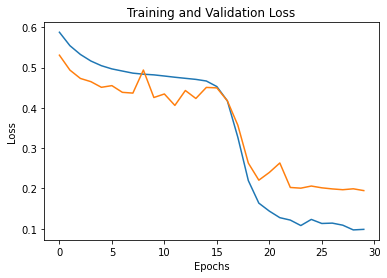

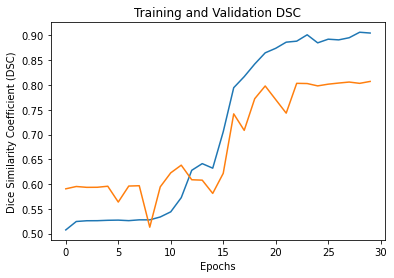

In [27]:
plt.figure(0)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.figure(1)
plt.plot(train_accuracies, label='Training DSC')
plt.plot(val_accuracies, label='Validation DSC')
plt.title('Training and Validation DSC')
plt.xlabel('Epochs')
plt.ylabel('Dice Similarity Coefficient (DSC)')

Load trained model

In [16]:
trained_model = UNet(
    in_channels=1,
    out_classes=2,
    dimensions=3,
    num_encoding_blocks=3,
    out_channels_first_layer=8,
    normalization='batch',
    upsampling_type='linear',
    padding=True,
    activation='ReLU',
).to(device)
trained_model.load_state_dict(torch.load("./whole_images_epoch_30.pth"))
trained_model.eval()
optimizer = torch.optim.AdamW(trained_model.parameters(), lr=1e-3)

Test trained model on test set

In [17]:
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    num_workers=num_workers,
)

# test_loss = run_epoch(0, Action.VALIDATE, test_loader, model, optimizer)
test_loss, test_accuracy = test(test_loader, trained_model, optimizer)

# print("Test loss: {0:.3f}".format(test_loss))

  0%|          | 0/15 [00:00<?, ?it/s]

C:\Users\Cherrie\anaconda3\envs\env3\lib\site-packages\unet\decoding.py:146: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  half_crop = crop // 2
C:\Users\Cherrie\anaconda3\envs\env3\lib\site-packages\torchio\transforms\preprocessing\spatial\crop_or_pad.py:216: RuntimeWarning: All values found in the mask "label" are zero. Using volume center instead
  warnings.warn(message, RuntimeWarning)


Test mean loss: 0.152
Test mean accuracy: 0.851


Segmenting image 1
ScalarImage(shape: (1, 256, 256, 128); spacing: (0.41, 0.41, 0.70); orientation: RAS+; dtype: torch.FloatTensor; memory: 32.0 MiB)
LabelMap(shape: (2, 256, 256, 128); spacing: (0.41, 0.41, 0.70); orientation: RAS+; dtype: torch.ByteTensor; memory: 16.0 MiB)


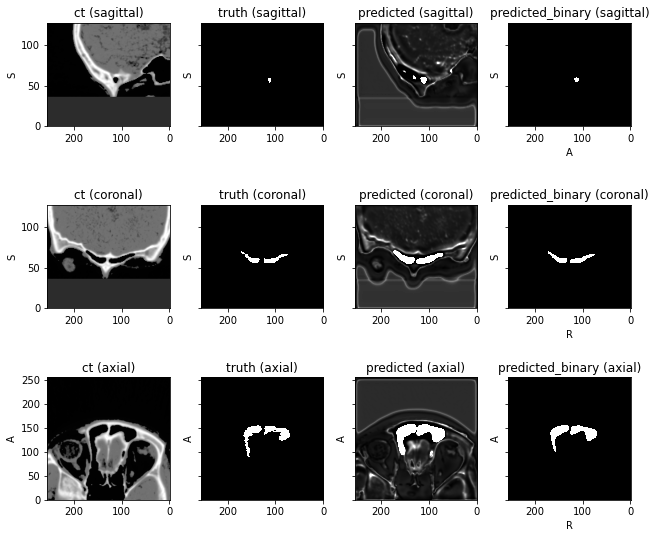

Segmenting image 2
ScalarImage(shape: (1, 256, 256, 128); spacing: (0.45, 0.45, 0.70); orientation: RAS+; dtype: torch.FloatTensor; memory: 32.0 MiB)
LabelMap(shape: (2, 256, 256, 128); spacing: (0.45, 0.45, 0.70); orientation: RAS+; dtype: torch.ByteTensor; memory: 16.0 MiB)


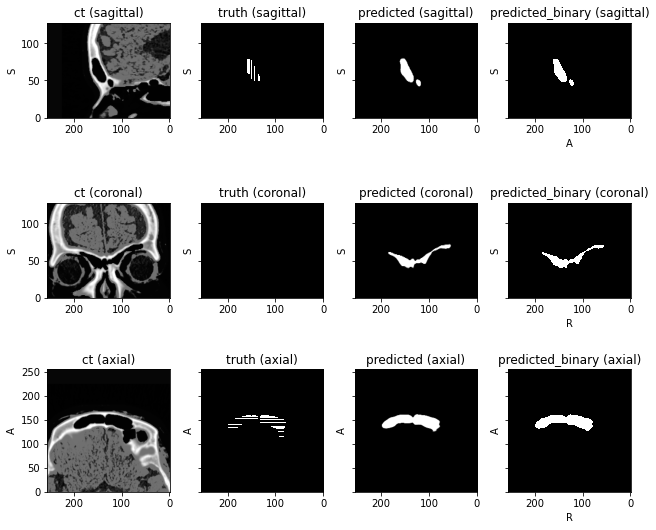

Segmenting image 3
ScalarImage(shape: (1, 256, 256, 128); spacing: (0.39, 0.39, 0.70); orientation: RAS+; dtype: torch.FloatTensor; memory: 32.0 MiB)
LabelMap(shape: (2, 256, 256, 128); spacing: (0.39, 0.39, 0.70); orientation: RAS+; dtype: torch.ByteTensor; memory: 16.0 MiB)


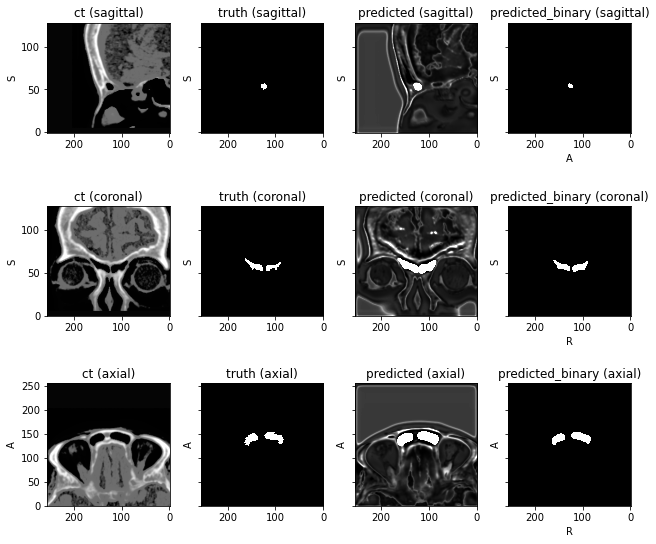

Segmenting image 4
ScalarImage(shape: (1, 256, 256, 128); spacing: (0.43, 0.43, 0.70); orientation: RAS+; dtype: torch.FloatTensor; memory: 32.0 MiB)
LabelMap(shape: (2, 256, 256, 128); spacing: (0.43, 0.43, 0.70); orientation: RAS+; dtype: torch.ByteTensor; memory: 16.0 MiB)


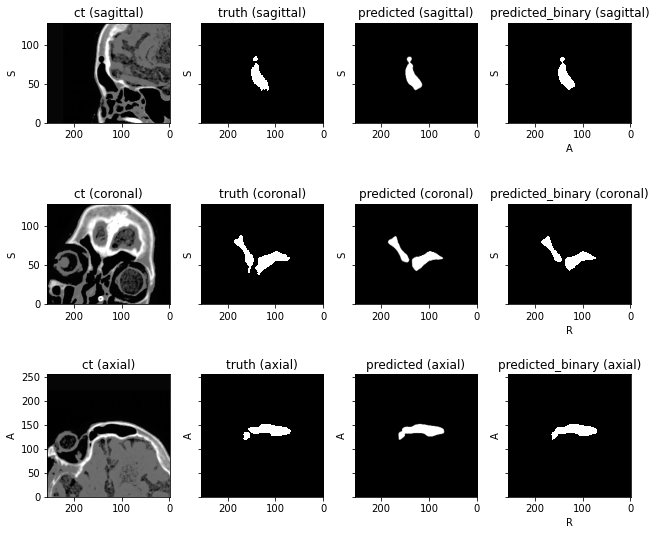

Segmenting image 5
ScalarImage(shape: (1, 256, 256, 128); spacing: (0.37, 0.37, 0.70); orientation: RAS+; dtype: torch.FloatTensor; memory: 32.0 MiB)
LabelMap(shape: (2, 256, 256, 128); spacing: (0.37, 0.37, 0.70); orientation: RAS+; dtype: torch.ByteTensor; memory: 16.0 MiB)


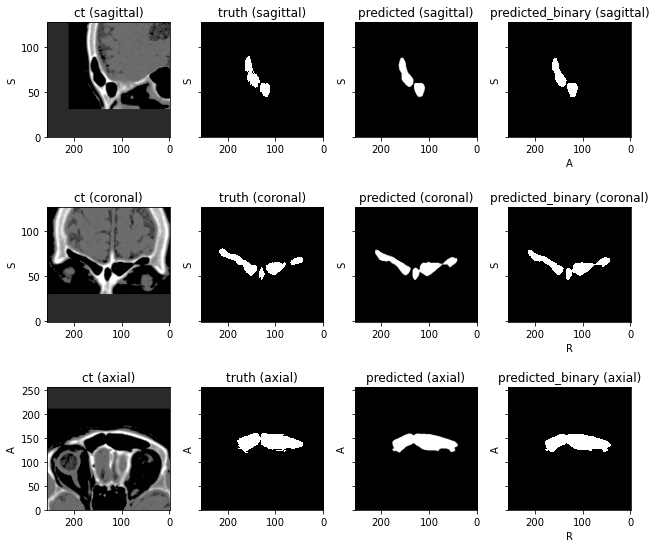

Segmenting image 6
ScalarImage(shape: (1, 256, 256, 128); spacing: (0.45, 0.45, 0.70); orientation: RAS+; dtype: torch.FloatTensor; memory: 32.0 MiB)
LabelMap(shape: (2, 256, 256, 128); spacing: (0.45, 0.45, 0.70); orientation: RAS+; dtype: torch.ByteTensor; memory: 16.0 MiB)


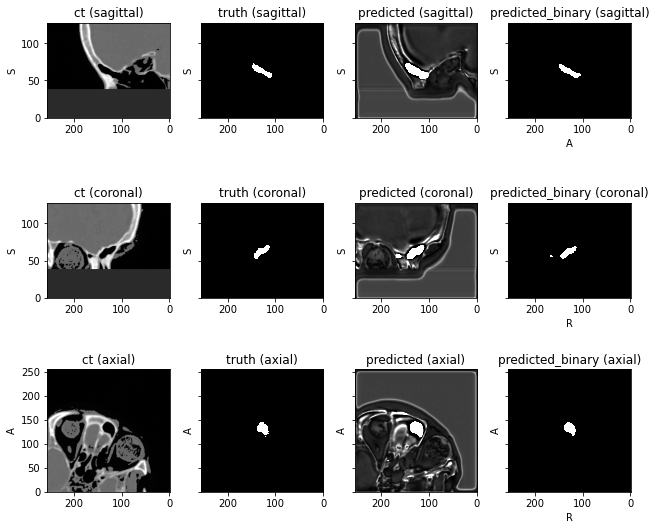

Segmenting image 7
ScalarImage(shape: (1, 256, 256, 128); spacing: (0.42, 0.42, 0.70); orientation: RAS+; dtype: torch.FloatTensor; memory: 32.0 MiB)
LabelMap(shape: (2, 256, 256, 128); spacing: (0.42, 0.42, 0.70); orientation: RAS+; dtype: torch.ByteTensor; memory: 16.0 MiB)


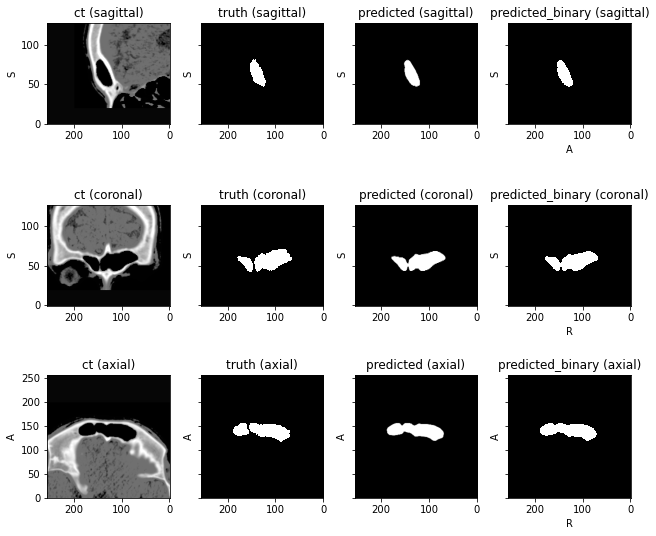

Segmenting image 8
ScalarImage(shape: (1, 256, 256, 128); spacing: (0.43, 0.43, 0.70); orientation: RAS+; dtype: torch.FloatTensor; memory: 32.0 MiB)
LabelMap(shape: (2, 256, 256, 128); spacing: (0.43, 0.43, 0.70); orientation: RAS+; dtype: torch.ByteTensor; memory: 16.0 MiB)


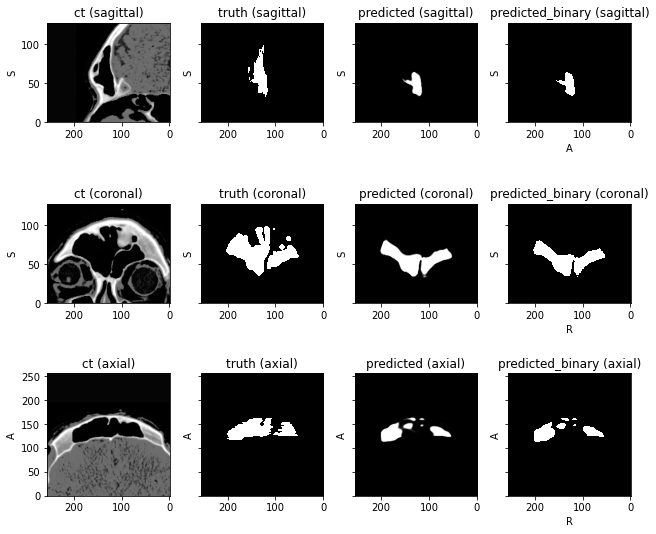

Segmenting image 9
ScalarImage(shape: (1, 256, 256, 128); spacing: (0.41, 0.41, 0.70); orientation: RAS+; dtype: torch.FloatTensor; memory: 32.0 MiB)
LabelMap(shape: (2, 256, 256, 128); spacing: (0.41, 0.41, 0.70); orientation: RAS+; dtype: torch.ByteTensor; memory: 16.0 MiB)


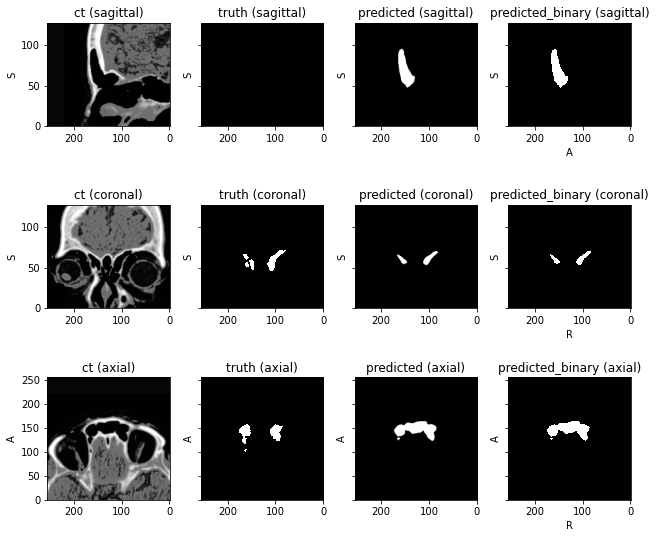

Segmenting image 10
ScalarImage(shape: (1, 256, 256, 128); spacing: (0.39, 0.39, 0.70); orientation: RAS+; dtype: torch.FloatTensor; memory: 32.0 MiB)
LabelMap(shape: (2, 256, 256, 128); spacing: (0.39, 0.39, 0.70); orientation: RAS+; dtype: torch.ByteTensor; memory: 16.0 MiB)


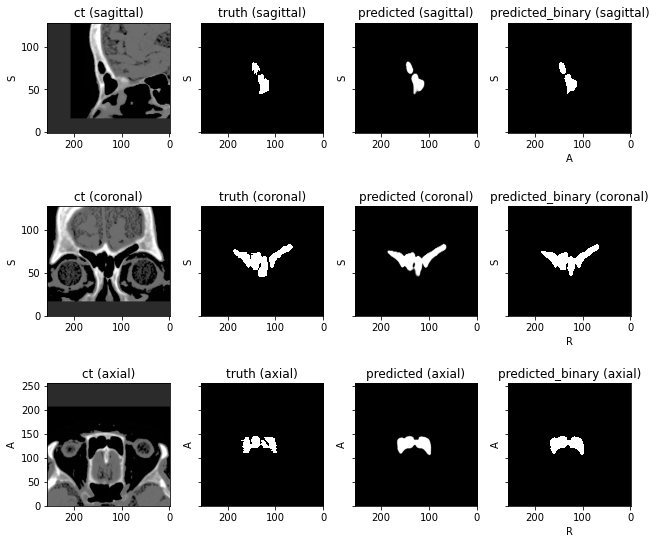

Segmenting image 11
ScalarImage(shape: (1, 256, 256, 128); spacing: (0.42, 0.42, 0.70); orientation: RAS+; dtype: torch.FloatTensor; memory: 32.0 MiB)
LabelMap(shape: (2, 256, 256, 128); spacing: (0.42, 0.42, 0.70); orientation: RAS+; dtype: torch.ByteTensor; memory: 16.0 MiB)


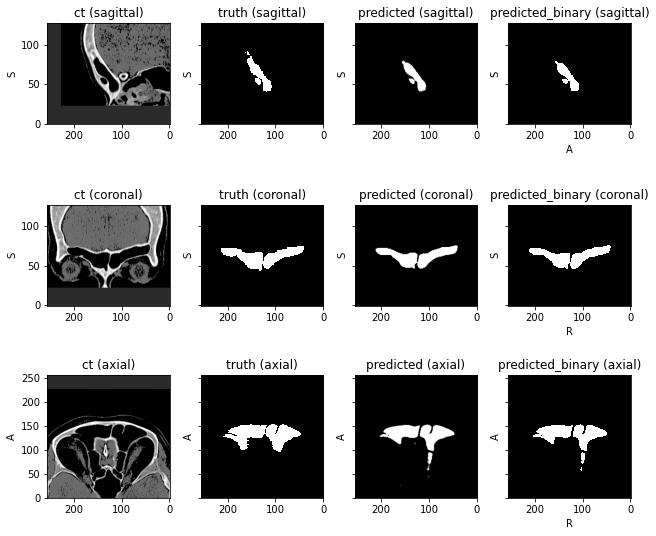

Segmenting image 12
ScalarImage(shape: (1, 256, 256, 128); spacing: (0.43, 0.43, 0.70); orientation: RAS+; dtype: torch.FloatTensor; memory: 32.0 MiB)
LabelMap(shape: (2, 256, 256, 128); spacing: (0.43, 0.43, 0.70); orientation: RAS+; dtype: torch.ByteTensor; memory: 16.0 MiB)


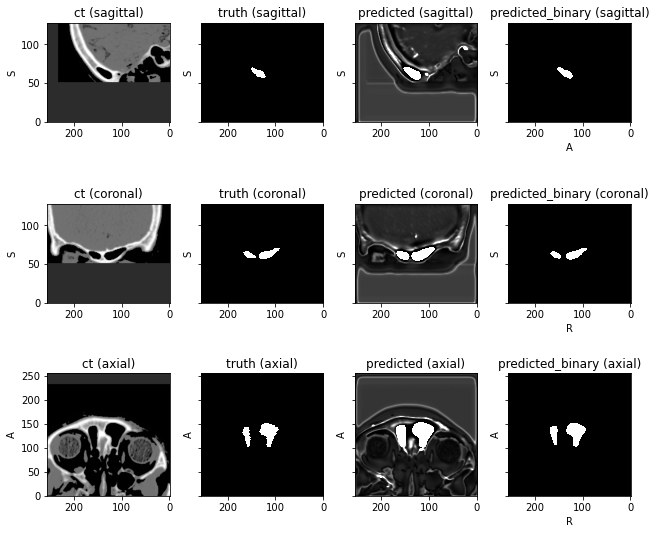

Segmenting image 13
ScalarImage(shape: (1, 256, 256, 128); spacing: (0.42, 0.42, 0.70); orientation: RAS+; dtype: torch.FloatTensor; memory: 32.0 MiB)
LabelMap(shape: (2, 256, 256, 128); spacing: (0.42, 0.42, 0.70); orientation: RAS+; dtype: torch.ByteTensor; memory: 16.0 MiB)


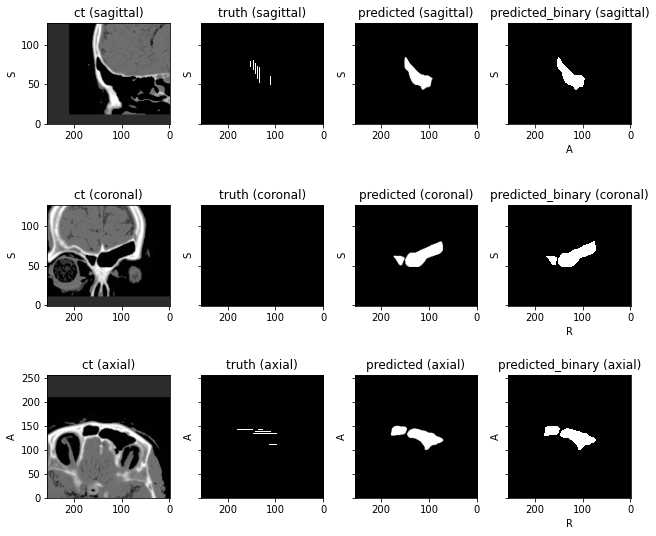

Segmenting image 14
ScalarImage(shape: (1, 256, 256, 128); spacing: (0.41, 0.41, 0.70); orientation: RAS+; dtype: torch.FloatTensor; memory: 32.0 MiB)
LabelMap(shape: (2, 256, 256, 128); spacing: (0.41, 0.41, 0.70); orientation: RAS+; dtype: torch.ByteTensor; memory: 16.0 MiB)


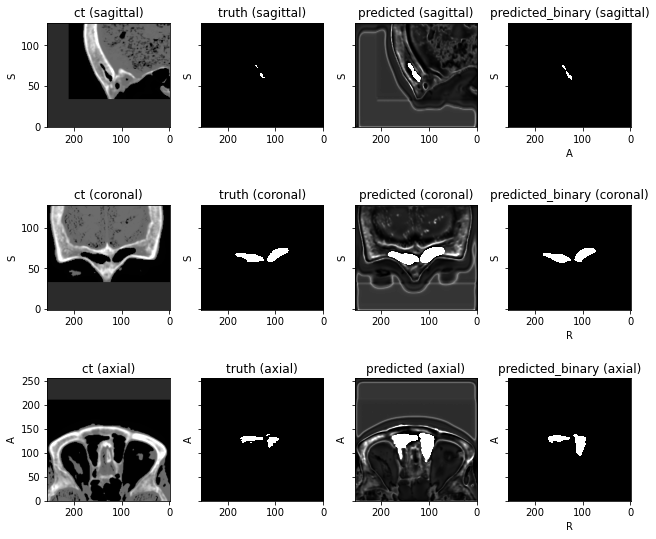

Segmenting image 15
ScalarImage(shape: (1, 256, 256, 128); spacing: (0.44, 0.44, 0.70); orientation: RAS+; dtype: torch.FloatTensor; memory: 32.0 MiB)
LabelMap(shape: (1, 256, 256, 128); spacing: (0.44, 0.44, 0.70); orientation: RAS+; dtype: torch.ByteTensor; memory: 8.0 MiB)


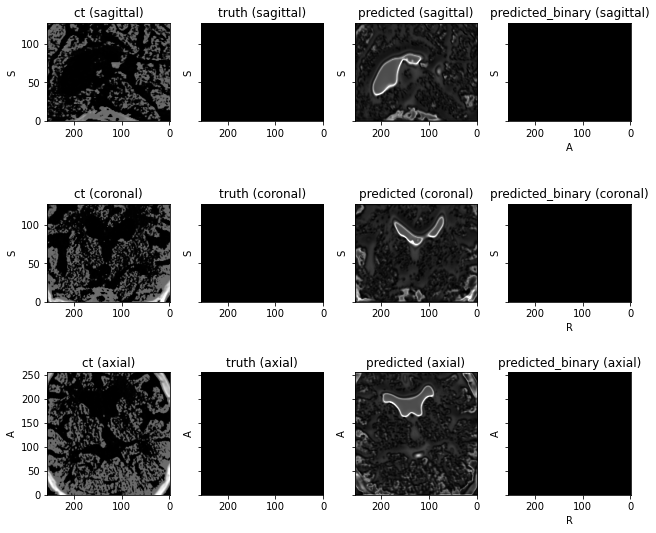

In [19]:
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    num_workers=num_workers,
)

generator = iter(test_loader)

for i in range(len(test_loader)):
    print("Segmenting image {0}".format(i+1))
    batch = next(generator)
    inputs, targets = prepare_batch(batch, device)    
    FIRST = 0
    FOREGROUND = 1
    with torch.no_grad():
#         probabilities = trained_model(inputs).softmax(dim=1)[:, FOREGROUND:].cpu()
#         probabilities = F.softmax(trained_model(inputs), dim=CHANNELS_DIMENSION)[:, FOREGROUND:].cpu()
#         probabilities = (trained_model(inputs)).cpu()
        probabilities = torch.sigmoid(trained_model(inputs)).cpu()
#         print(probabilities.shape)
    affine = batch['label'][tio.AFFINE][0].numpy()
    subject = tio.Subject(
        ct=tio.ScalarImage(tensor=batch['img'][tio.DATA][0], affine=affine),
        truth=tio.LabelMap(tensor=batch['label'][tio.DATA][0], affine=affine),
        predicted=tio.ScalarImage(tensor=(probabilities[0]), affine=affine),
#         predicted2= tio.ScalarImage(tensor=torch.sigmoid(probabilities[0]), affine=affine),
        predicted_binary= tio.LabelMap(tensor=(probabilities[0]>0.5), affine=affine)
    )
    print(subject.ct)
    print(subject.truth)
    # subject.plot(figsize=(9, 8), cmap_dict={'predicted': 'RdBu_r'})
    # binry(subject).plot(figsize=(9, 8))
    subject.plot(figsize=(9, 8))



In [20]:
for i, subject in enumerate(test_set.dry_iter()):
    subject['img'].save("./testset88/testimg{0}.nii".format(i+1))
    subject['label'].save("./testset88/testlabel{0}.nii".format(i+1))